In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import requests

In [2]:
fname = 'kn_scores_kndetect_both_models.parquet'

In [3]:
data = pd.read_parquet(fname)

In [4]:
data.shape

(2350, 10)

In [5]:
data

,objectId,candid,cdsxmatch,knscore_complete,knscore_partial,rf_kn_vs_nonkn,cjd,cfid,cmagpsf,csigmapsf
0,ZTF21abjerft,1649291810415015014,Fail,0.533333,0.005464,0.000000,"[2459374.8668866, 2459374.9252662, 2459376.817...","[1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,ZTF21abitmou,1649358355115015017,Fail,0.400000,0.114299,0.566667,"[2459373.8971065, 2459374.8975694, 2459374.919...","[2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,ZTF21abiuzyl,1649334965515015030,Unknown,0.666667,0.365744,0.000000,"[2459374.8975694, 2459374.9196181, 2459376.897...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,ZTF21abixemm,1648307602215015002,Unknown,0.533333,0.105513,0.000000,"[2459373.8425231, 2459375.8722106, 2459375.887...","[1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,ZTF20acoyfpk,1413202324215015013,Unknown,0.628964,0.527370,0.000000,"[2459138.7203472, 2459138.7894329, 2459140.701...","[1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...,...,...,...,...,...,...
2345,ZTF21abdvbmm,1619438723615015004,Galaxy,0.533333,0.069478,0.000000,"[2459368.9283565, 2459370.9266435, 2459370.981...","[2, 1, 2, 1]","[19.221799850463867, 19.409000396728516, 18.97...","[0.17678700387477875, 0.1798509955406189, 0.10..."
2346,ZTF20acptgfl,1413477786315015001,Unknown,0.830623,0.417396,0.000000,"[2459140.8742824, 2459141.0026273, 2459142.938...","[2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2347,ZTF20acqutkc,1415522745115010014,Unknown,0.600000,0.200806,0.066667,"[2459167.9801968, 2459168.9803125, 2459169.022...","[2, 1, 2, 1, 2]","[nan, 18.47170066833496, 17.713300704956055, 1...","[nan, 0.08982499688863754, 0.1427460014820099,..."
2348,ZTF20acpicjz,1413514511515015003,Unknown,0.836590,0.798335,0.000000,"[2459139.9093634, 2459141.8653588, 2459141.934...","[1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [6]:
sum(data['knscore_complete'] > 0.5)

1637

In [7]:
sum(data['knscore_partial'] > 0.5)

400

In [8]:
sum(data['rf_kn_vs_nonkn']>0.5)

251

In [9]:
from fink_utils.photometry.conversion import mag2fluxcal_snana
from kndetect.utils import load_pcs
from kndetect.predict import load_classifier, predict_kn_score
from kndetect.features import extract_features_all_lightcurves, get_feature_names, calc_prediction

model = load_classifier("partial.pkl")
pcs = load_pcs()
filters = ['g', 'r']

new_model_scores = []
predicted_features = []

features_df = None

for indx, row in data.iterrows():
    #indx = list(data['candid'].values).index(lcs_complete.iloc[pos]['candid'])
    flag = [data['cmagpsf'].iloc[indx][i] != None for i in range(len(data['cmagpsf'].iloc[indx]))]

    mag = np.array(row['cmagpsf'])[flag]
    magerr = np.array(data.iloc[indx]['csigmapsf'])[flag]

    flux_data = [mag2fluxcal_snana(*args) for args in zip(
        mag,
        magerr)]
    flux, error = np.transpose(flux_data)

    lc = {}
    lc['SNID'] =  indx
    lc['MJD'] = np.array(data.iloc[indx]['cjd'])[flag]
    lc['FLT'] = pd.Series(np.array(data.iloc[indx]['cfid'])[flag])
    lc['FLT'].replace({1: 'g', 2: 'r'}, inplace=True)

    lc['FLUXCAL'] = flux
    lc['FLUXCALERR'] = error

    pdf = pd.DataFrame.from_dict(lc)
    current_features_df = extract_features_all_lightcurves(pdf, key="SNID", pcs=pcs, filters=filters)
    #features = features_df.iloc[0].values
    #predicted_features.append(features)
    
    if features_df is None:
        features_df = current_features_df
    else:
        features_df=pd.concat([features_df, current_features_df], axis=0)



In [10]:
features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key
0,1.011825,-0.041399,0.085002,0.289910,868.000649,1.043548,-0.007897,0.014255,0.161329,757.949373,0
0,0.747497,0.298141,-0.073594,2.781713,24721.802875,0.744134,0.271112,-0.051073,2.555533,24703.569168,1
0,0.935140,-0.048911,0.124250,1.337678,1690.906756,1.116561,-0.022356,0.005689,0.594734,2940.629073,2
0,1.195388,-0.096671,0.016503,0.543074,1069.644973,0.973288,-0.030066,0.090652,0.870216,985.280819,3
0,0.656590,0.257886,0.300637,6.542929,37646.119358,0.829674,0.123960,0.169640,3.009250,51843.123813,4
...,...,...,...,...,...,...,...,...,...,...,...
0,1.022819,-0.013323,0.040171,0.551380,2050.561805,0.999935,-0.026329,0.047527,0.951283,2564.247619,2345
0,1.078959,-0.006883,0.001751,0.108691,1178.907681,1.000811,-0.026247,0.052100,0.421743,1384.231247,2346
0,1.044212,0.004074,-0.001743,0.257174,4086.201065,0.948013,0.025825,-0.011045,0.615224,8216.364888,2347
0,0.934240,-0.054695,0.108569,0.961121,1397.432407,0.934536,-0.054568,0.108318,0.801169,1352.570693,2348


In [11]:
get_feature_names()

['coeff1_g',
 'coeff2_g',
 'coeff3_g',
 'residuo_g',
 'maxflux_g',
 'coeff1_r',
 'coeff2_r',
 'coeff3_r',
 'residuo_r',
 'maxflux_r']

In [12]:
probabilities_, _ = predict_kn_score(clf=model, features_df=features_df);
#print(probabilities_.T[1])
new_model_scores.extend(probabilities_.T[1])
data["new_model_scores"] = new_model_scores

In [13]:
print("Number of events classified KN with new model: "+str(np.sum(np.array(new_model_scores)>=0.5)))

Number of events classified KN with new model: 265


In [14]:
print("Number of events in common with old model: "+str(np.sum((np.array(new_model_scores)>=0.5) & (data['rf_kn_vs_nonkn']>0.5))))

Number of events in common with old model: 81


Text(0, 0.5, 'N')

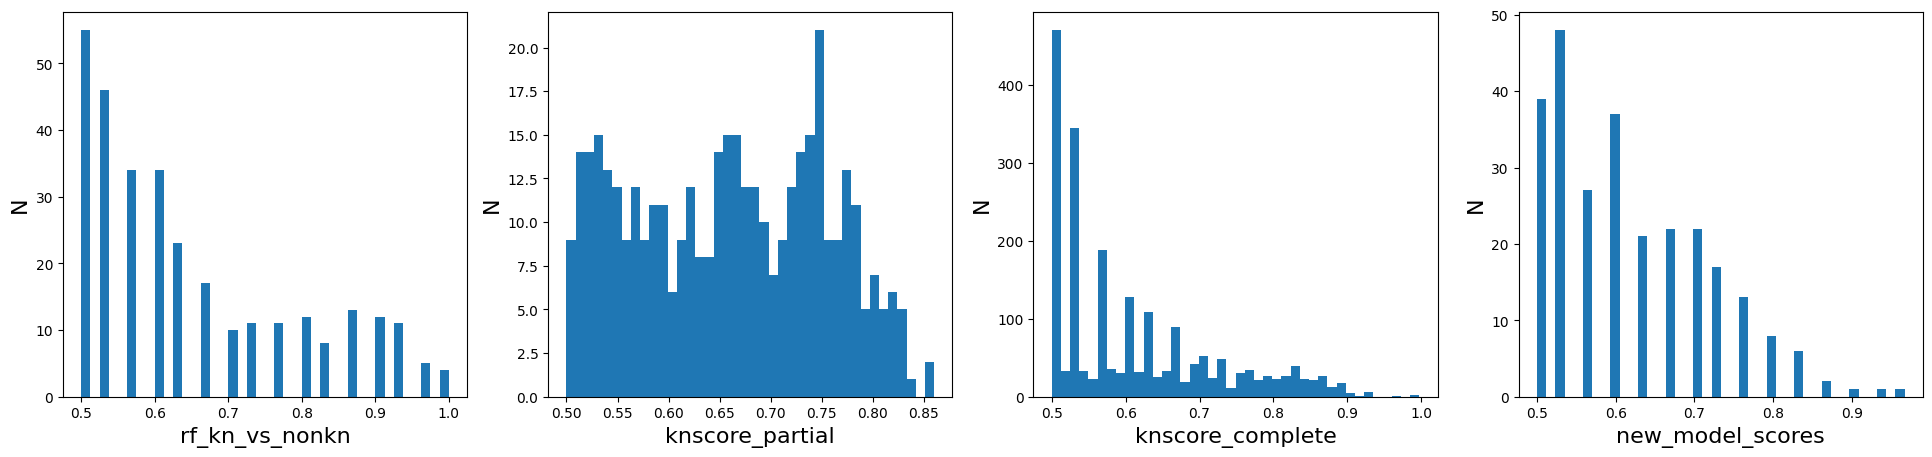

In [15]:
plt.figure(figsize=(24,5))

plt.subplot(1,4,1)
plt.hist(data['rf_kn_vs_nonkn'][data['rf_kn_vs_nonkn'] >= 0.5], bins=40)
plt.xlabel('rf_kn_vs_nonkn', fontsize=16)
plt.ylabel('N', fontsize=16)

plt.subplot(1,4,2)
plt.hist(data['knscore_partial'][data['knscore_partial'] >= 0.5], bins=40)
plt.xlabel('knscore_partial', fontsize=16)
plt.ylabel('N', fontsize=16)

plt.subplot(1,4,3)
plt.hist(data['knscore_complete'][data['knscore_complete'] >= 0.5], bins=40)
plt.xlabel('knscore_complete', fontsize=16)
plt.ylabel('N', fontsize=16)

plt.subplot(1,4,4)
plt.hist(data['new_model_scores'][data['new_model_scores'] >= 0.5], bins=40)
plt.xlabel('new_model_scores', fontsize=16)
plt.ylabel('N', fontsize=16)


Text(0, 0.5, 'rf_kn_vs_nonkn')

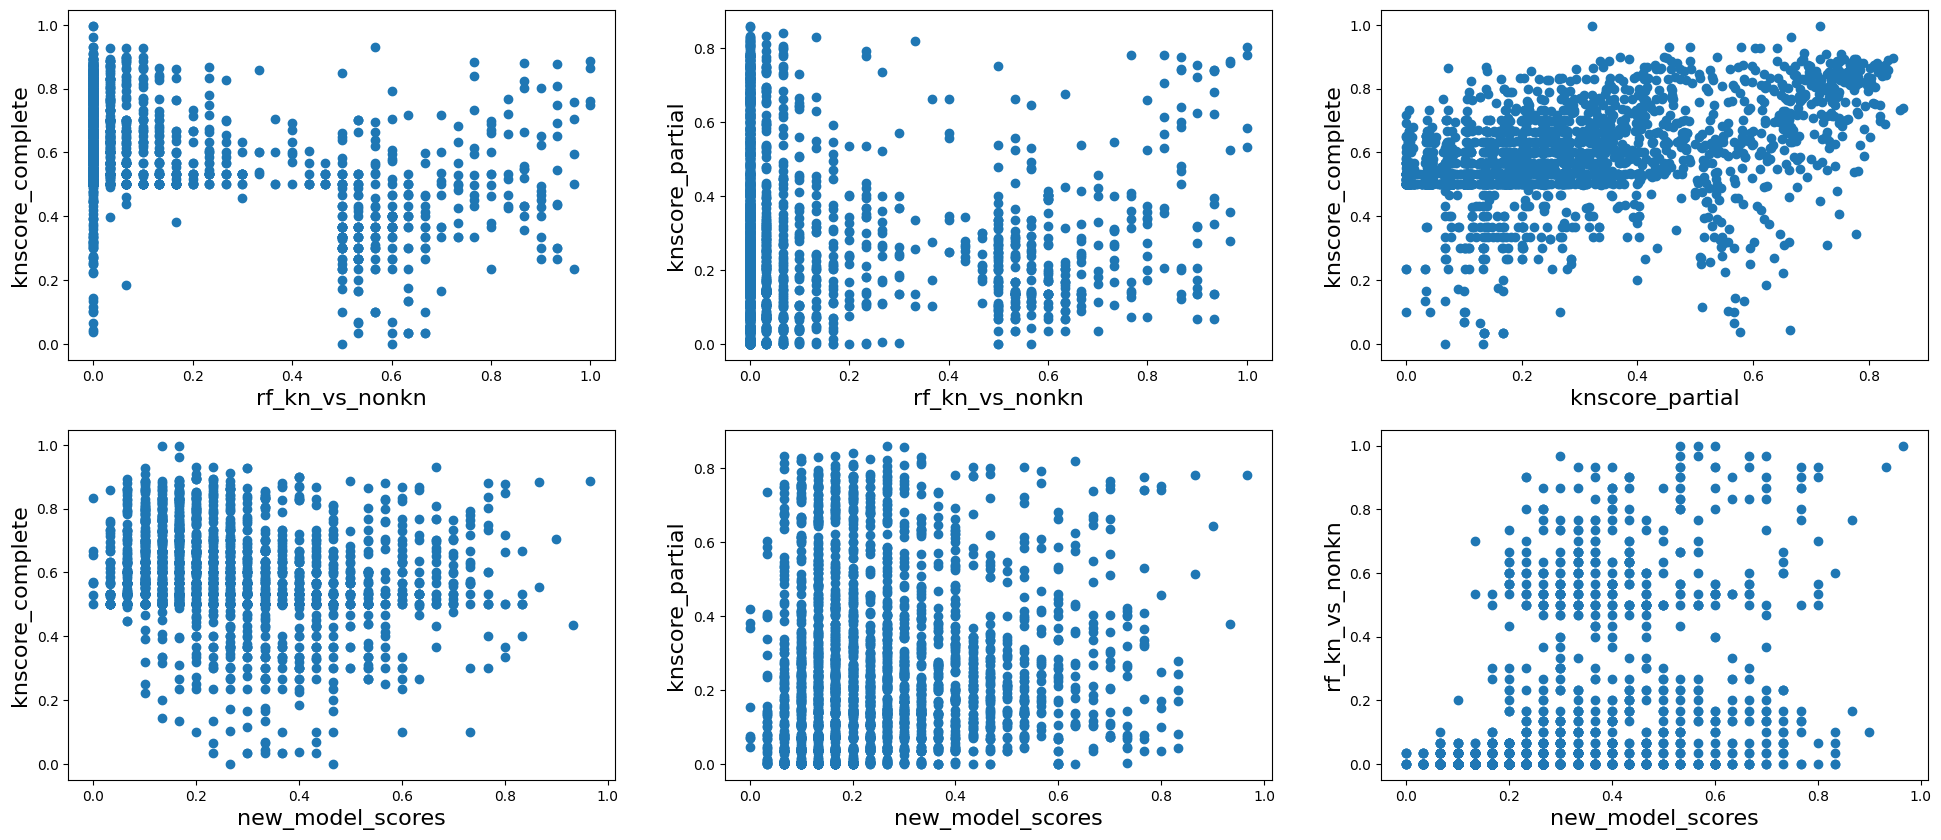

In [16]:
plt.figure(figsize=(24,10))

plt.subplot(2,3,1)
plt.scatter(data['rf_kn_vs_nonkn'], data['knscore_complete'])
plt.xlabel('rf_kn_vs_nonkn', fontsize=16)
plt.ylabel('knscore_complete', fontsize=16)

plt.subplot(2,3,2)
plt.scatter(data['rf_kn_vs_nonkn'], data['knscore_partial'])
plt.xlabel('rf_kn_vs_nonkn', fontsize=16)
plt.ylabel('knscore_partial', fontsize=16)

plt.subplot(2,3,3)
plt.scatter(data['knscore_partial'], data['knscore_complete'])
plt.xlabel('knscore_partial', fontsize=16)
plt.ylabel('knscore_complete', fontsize=16)

plt.subplot(2,3,4)
plt.scatter(data['new_model_scores'], data['knscore_complete'])
plt.xlabel('new_model_scores', fontsize=16)
plt.ylabel('knscore_complete', fontsize=16)

plt.subplot(2,3,5)
plt.scatter(data['new_model_scores'], data['knscore_partial'])
plt.xlabel('new_model_scores', fontsize=16)
plt.ylabel('knscore_partial', fontsize=16)

plt.subplot(2,3,6)
plt.scatter(data['new_model_scores'], data['rf_kn_vs_nonkn'])
plt.xlabel('new_model_scores', fontsize=16)
plt.ylabel('rf_kn_vs_nonkn', fontsize=16)

#plt.savefig('plots/scatter_scores.png')

In [17]:
lcs_complete = data[data['new_model_scores'] >= 0.5]

In [18]:
lcs_complete.shape

(265, 11)

In [19]:
ids = list(data['objectId'].values)

## 

In [20]:
def get_band_coeff_dict(features):
    band_coeff_dict = {}
    for band in ['g', 'r']:
        coeffs =[]
        for pc_num in range(3):
            coeffs.append(features["coeff" + str(pc_num+1) + "_" + band])
            
        if band == 'g':
            band_coeff_dict[b'g'] = coeffs
        else:
            band_coeff_dict[b'r'] = coeffs
    return band_coeff_dict

In [21]:
predicted_features

[]

0.6


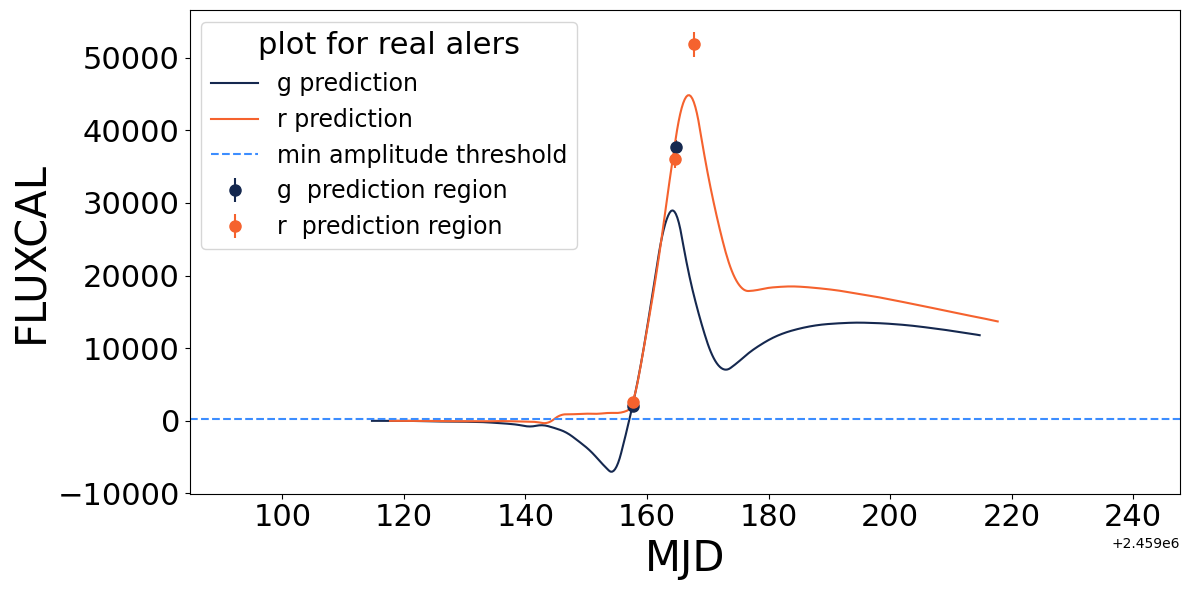

0.6


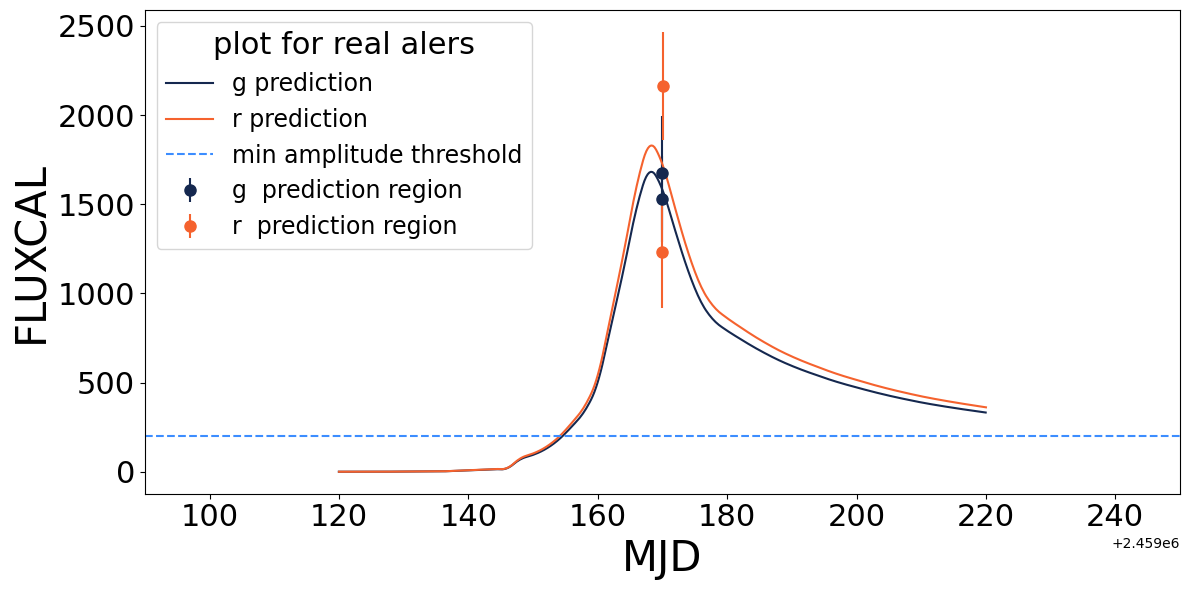

0.6


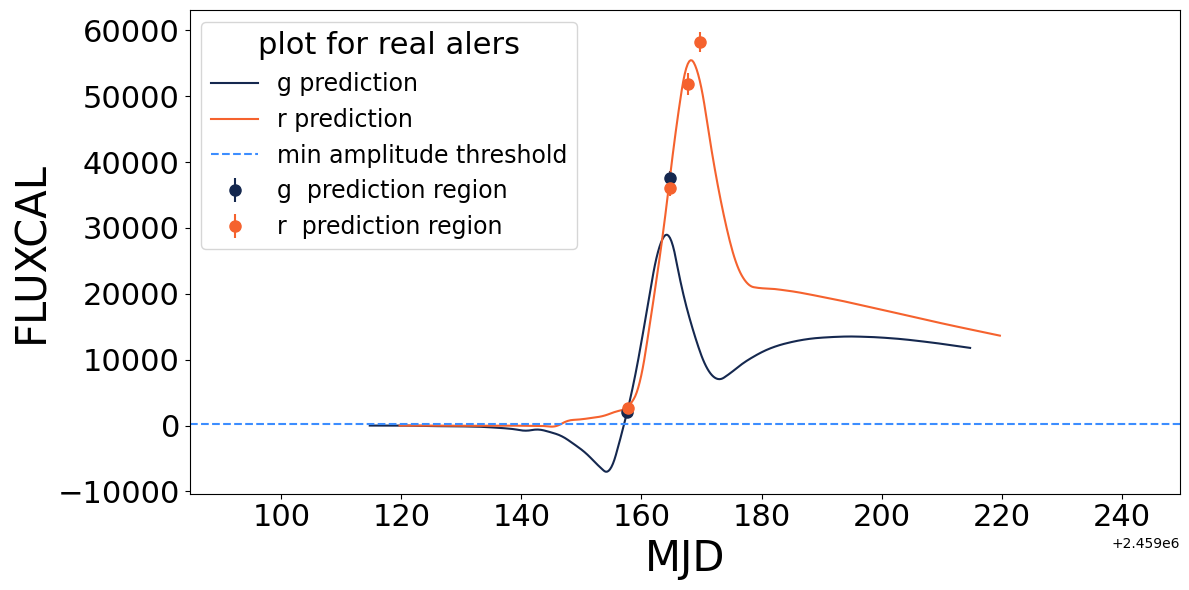

0.6666666666666666


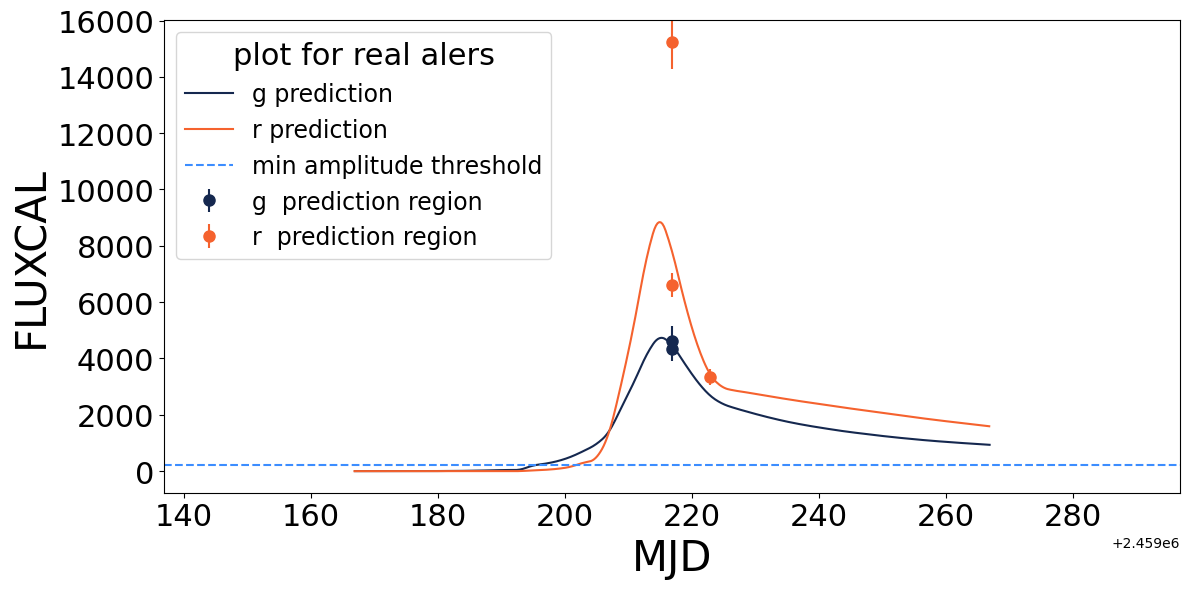

0.6666666666666666


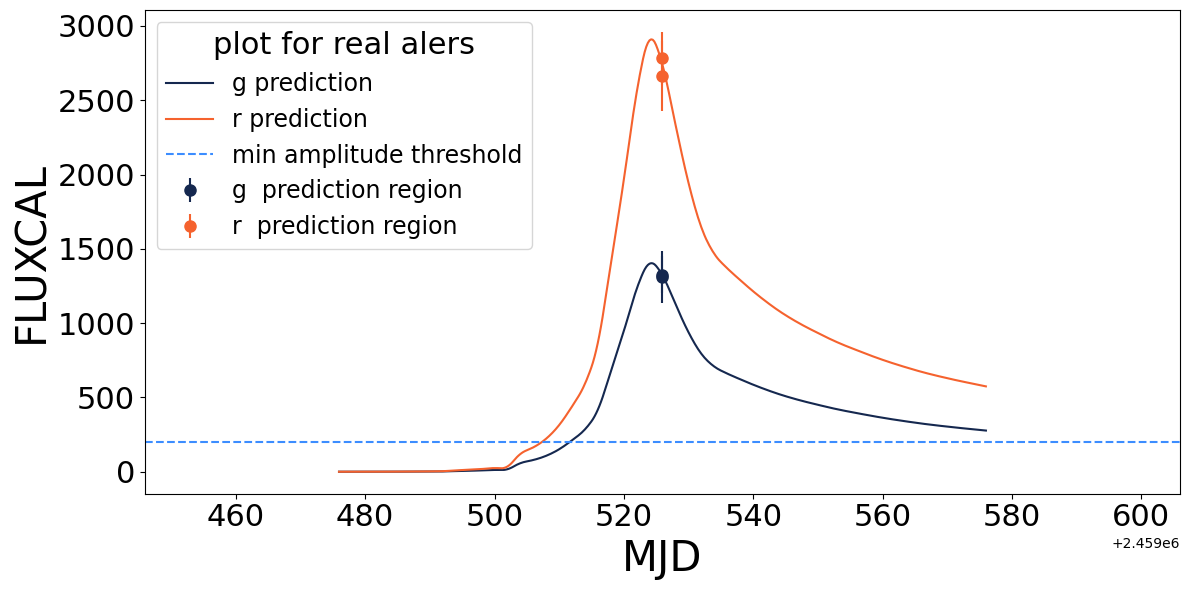

0.6666666666666666


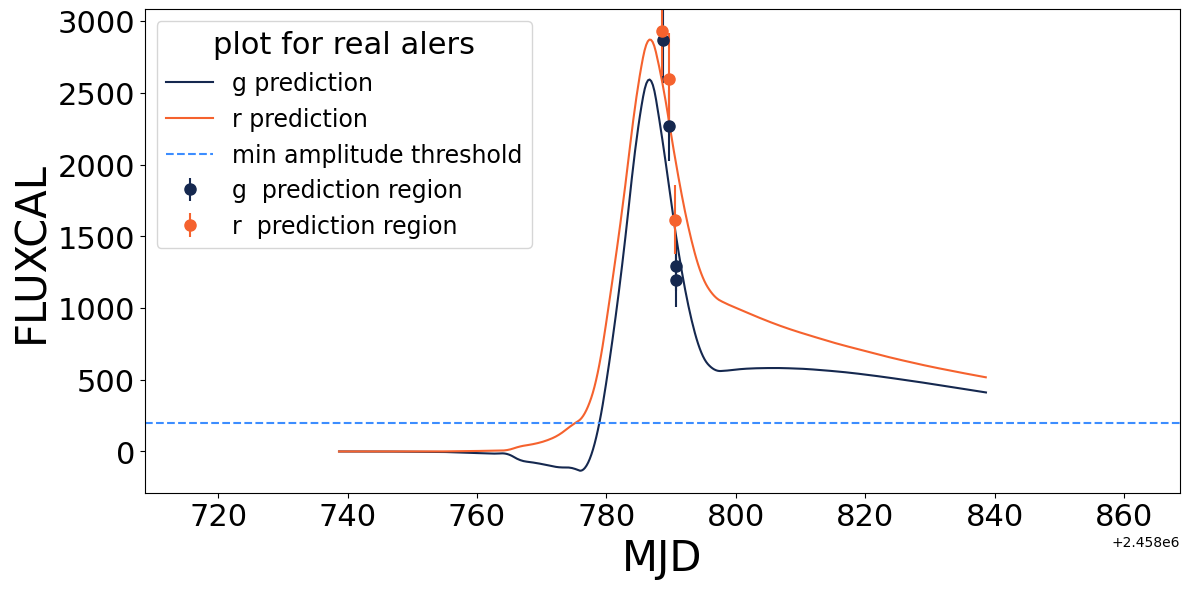

0.7


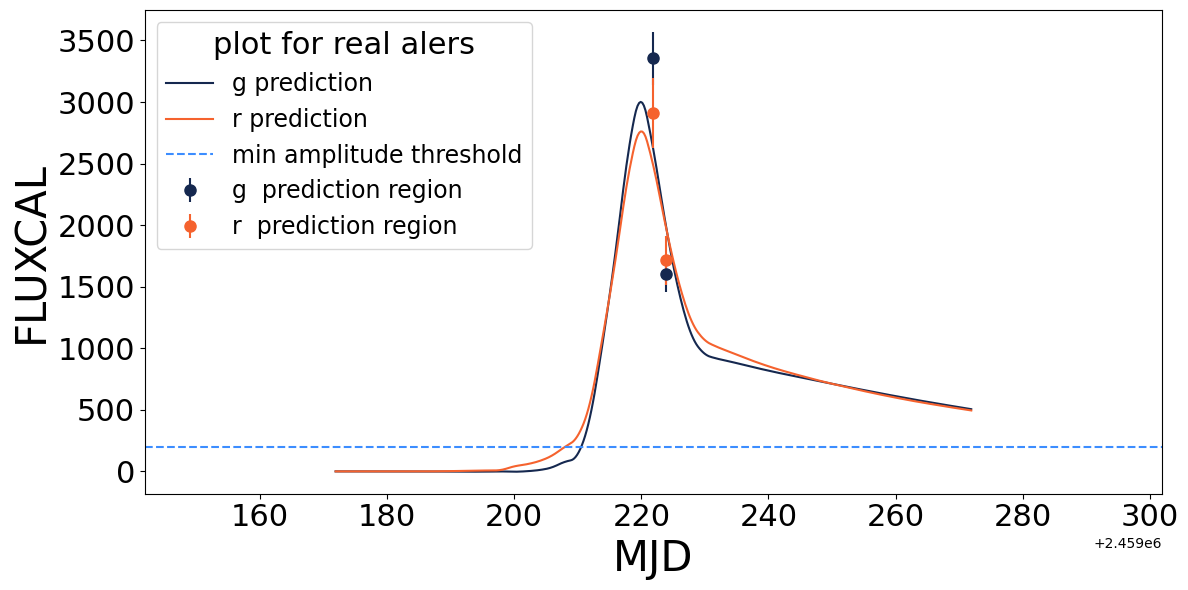

0.8


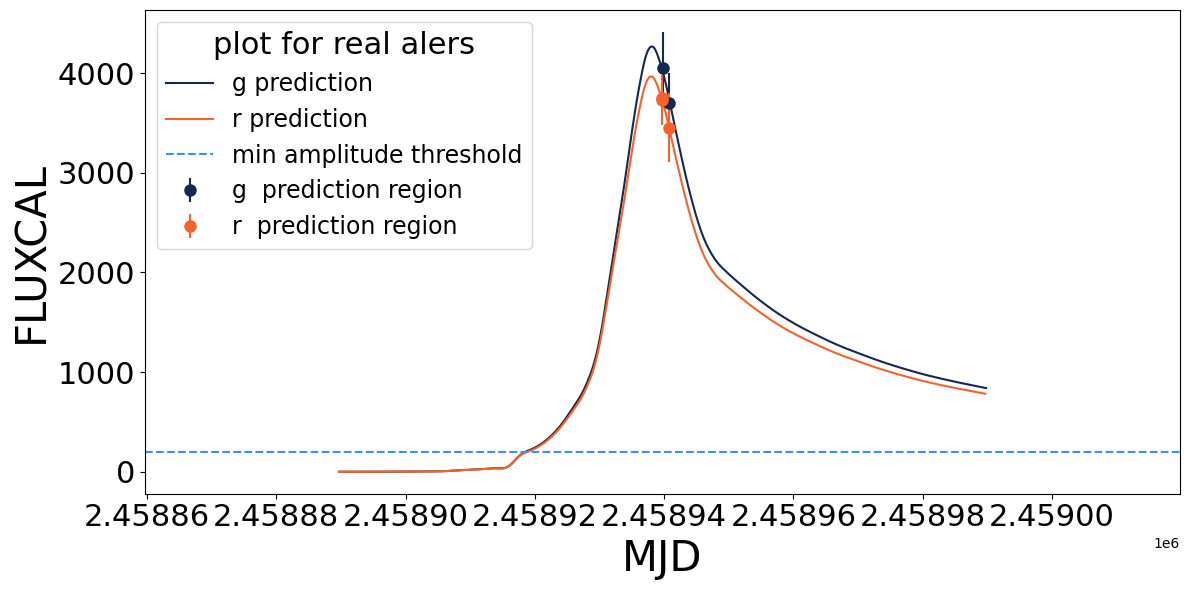

0.5333333333333333


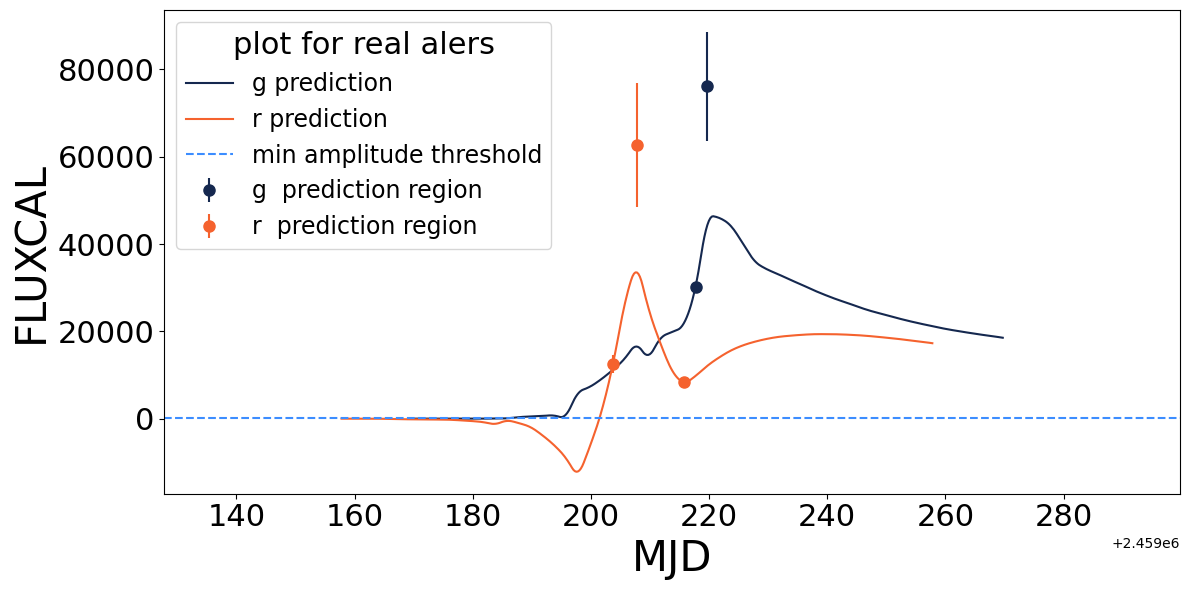

0.6


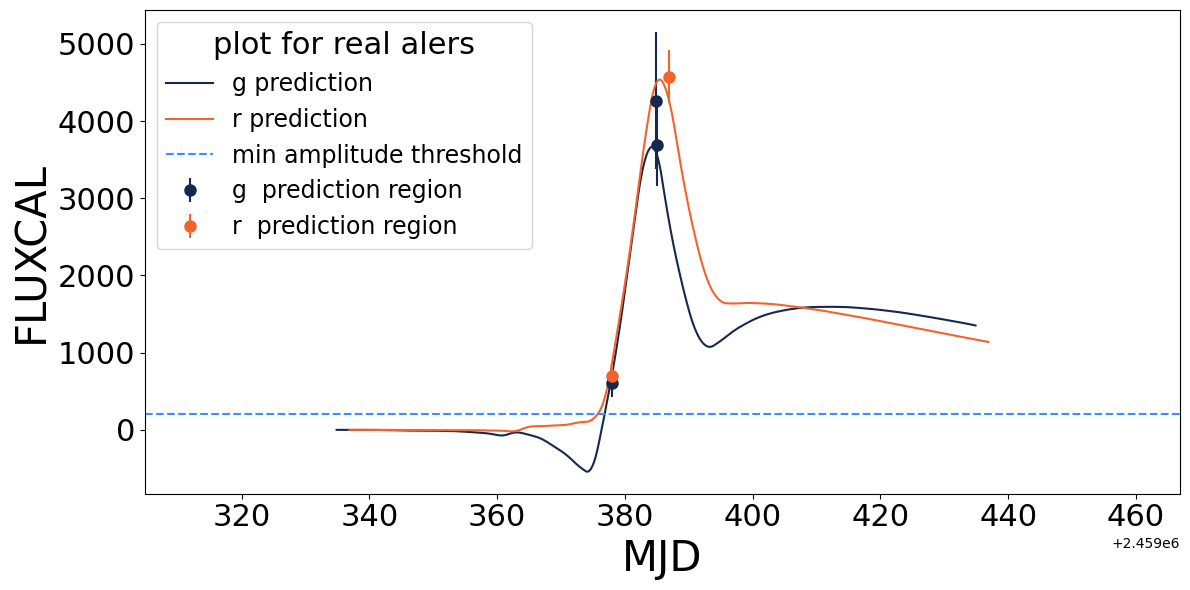

0.8333333333333334


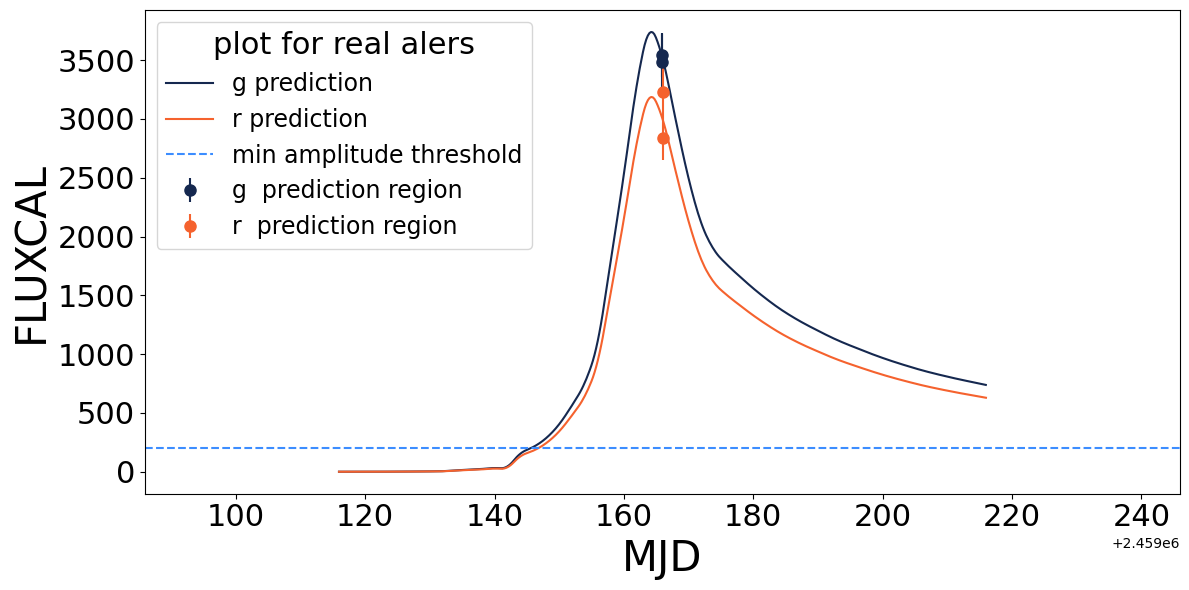

0.6666666666666666


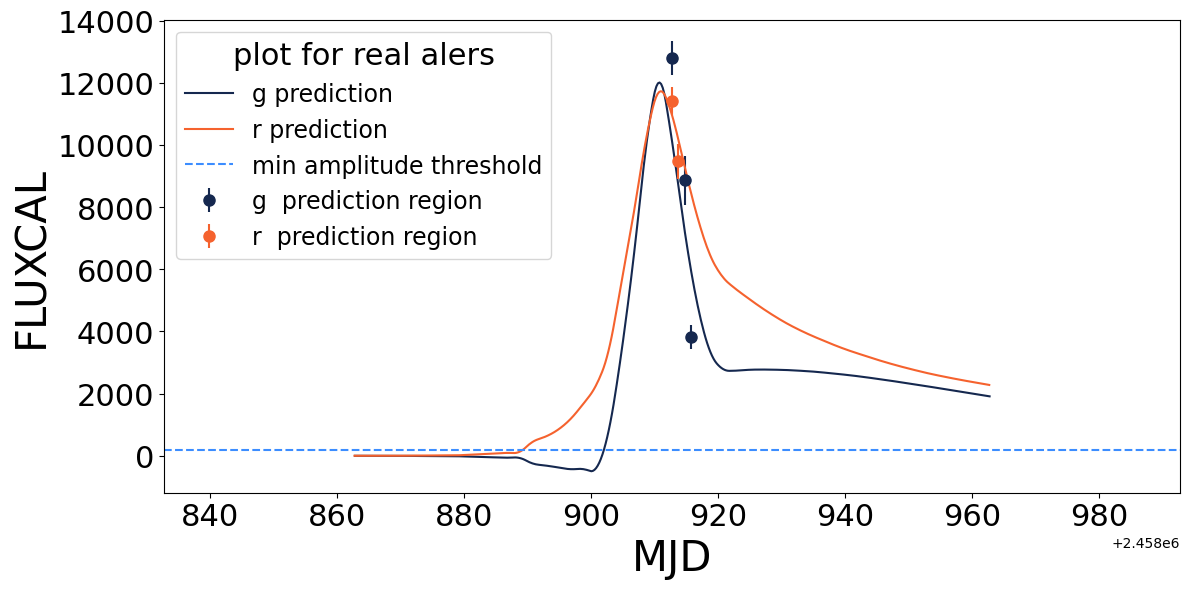

0.5333333333333333


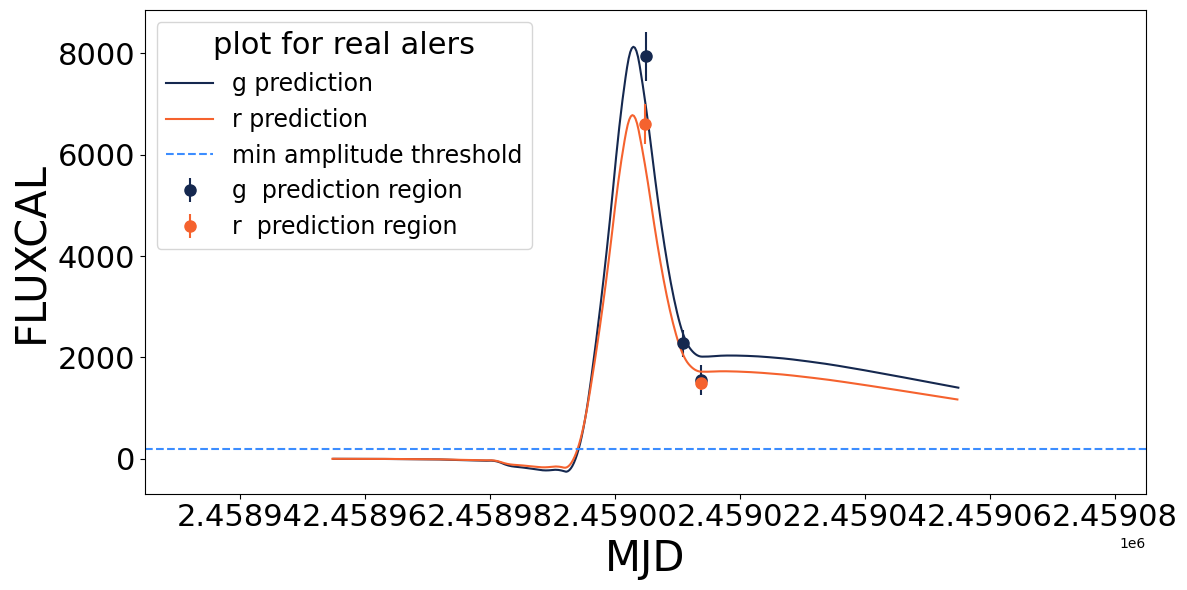

0.5333333333333333


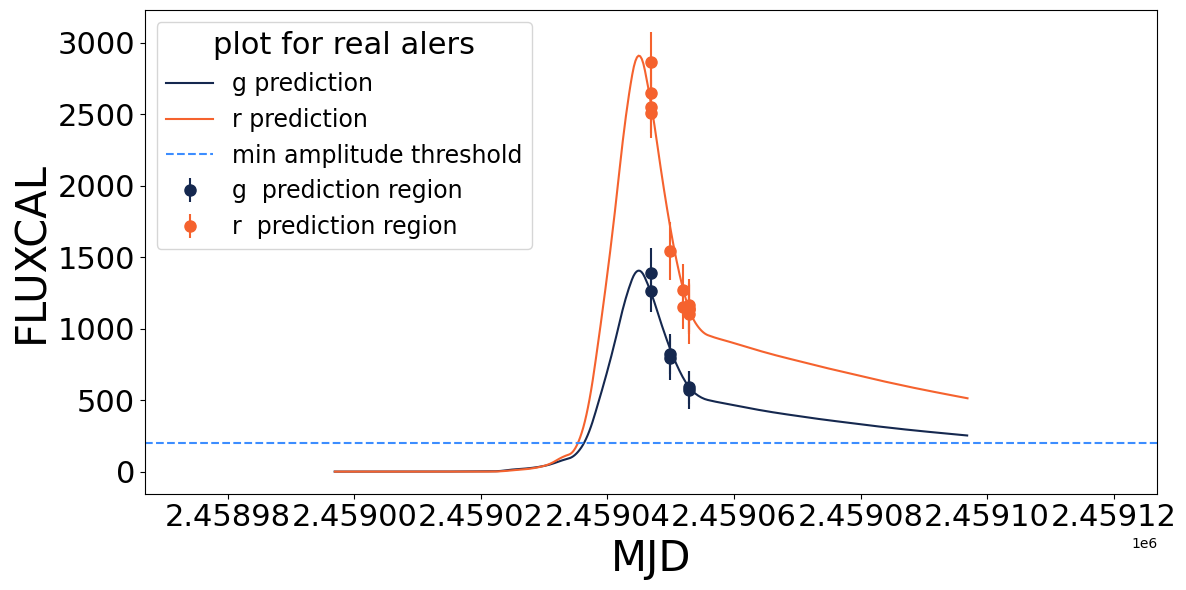

0.6333333333333333


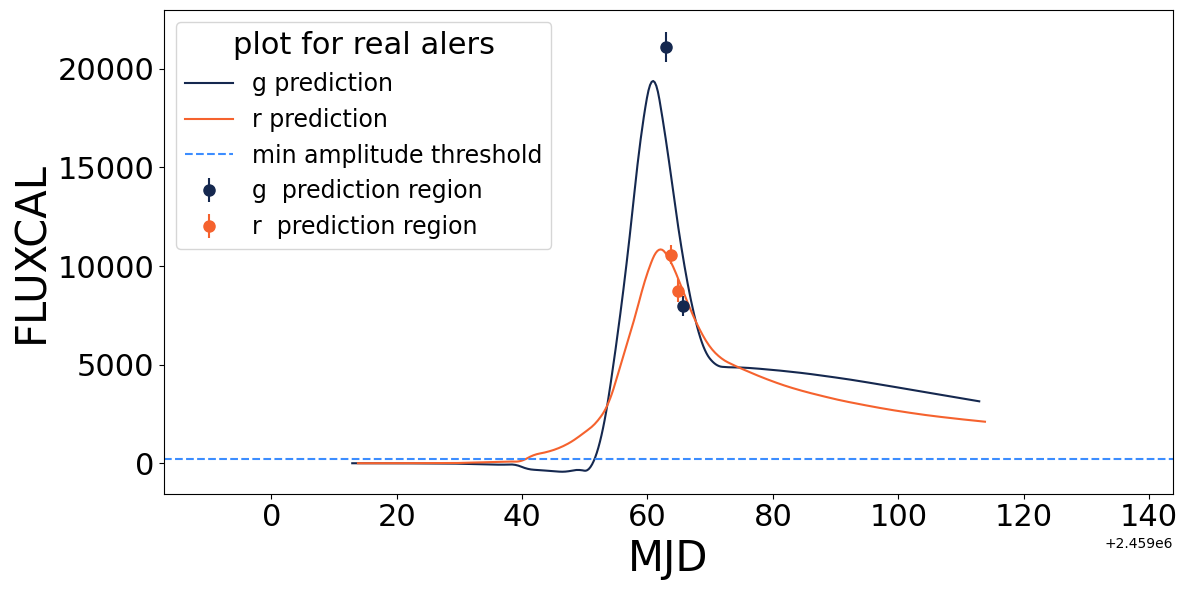

0.7333333333333333


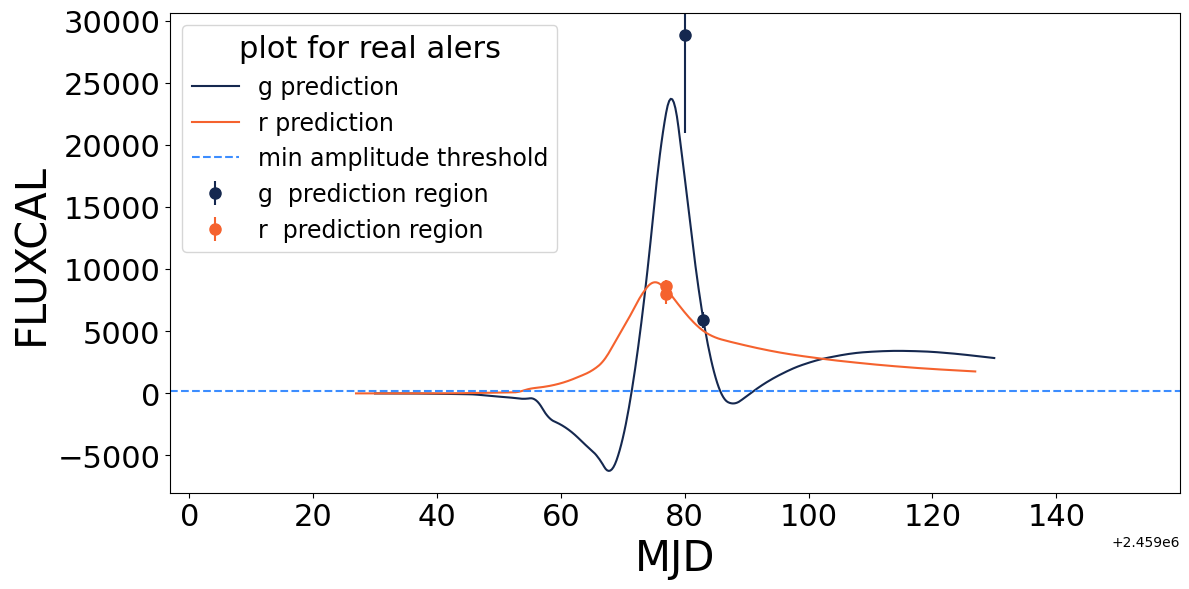

0.5666666666666667


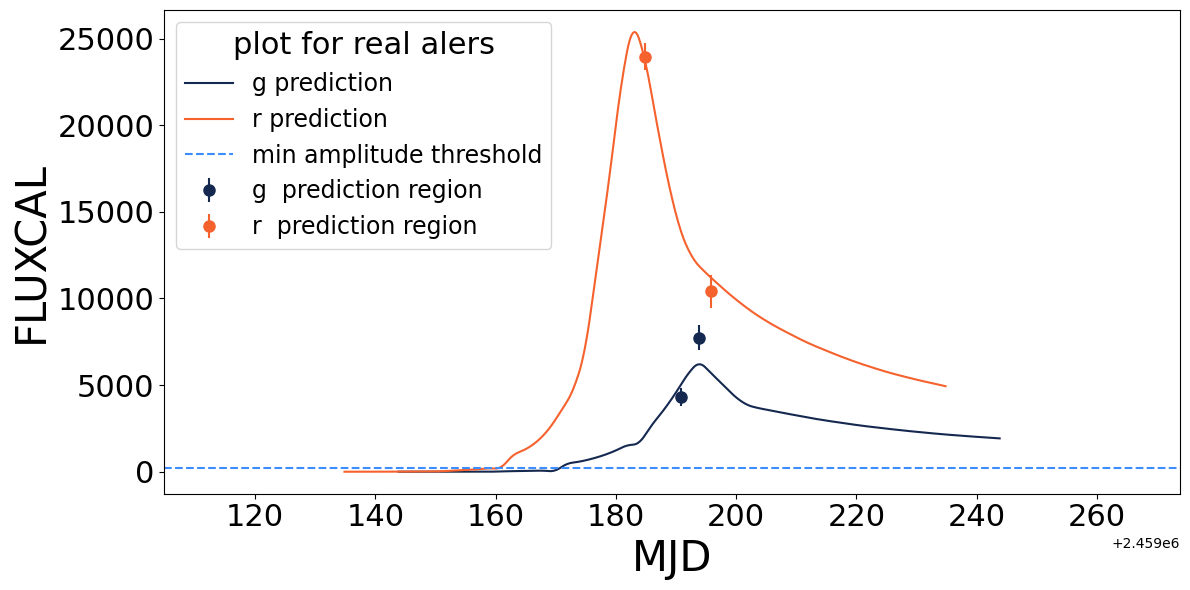

0.7666666666666667


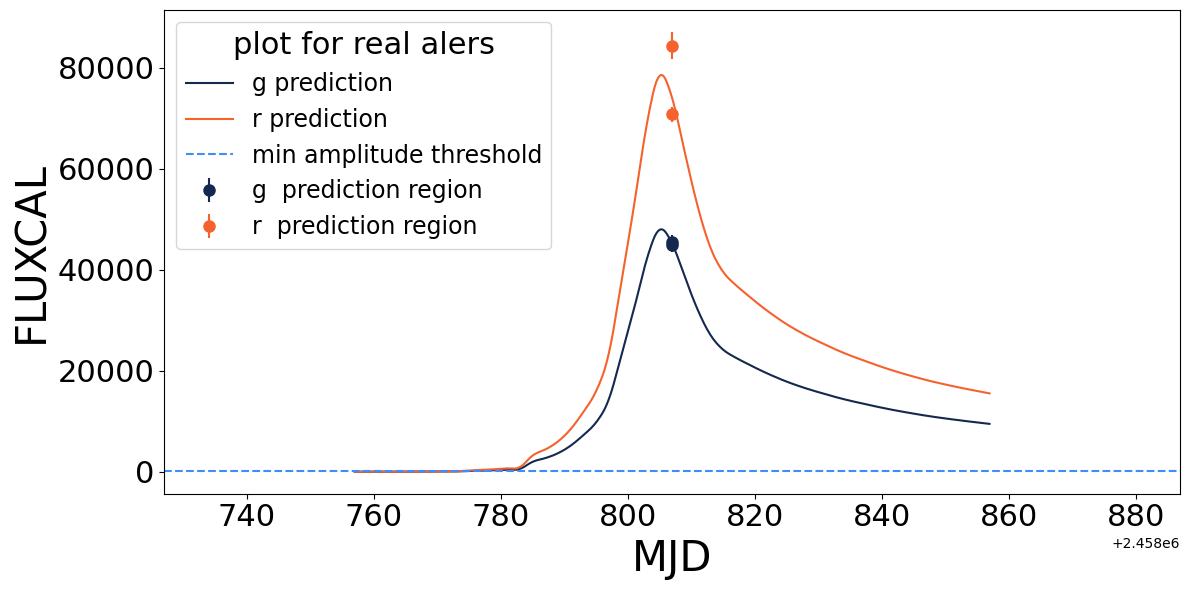

0.8666666666666667


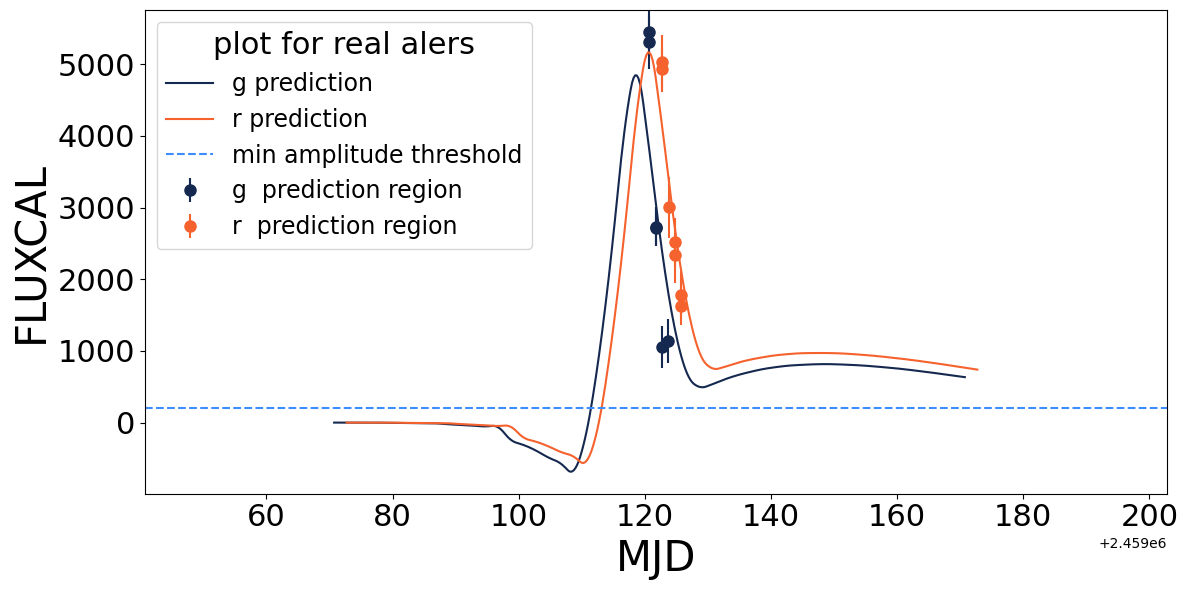

0.5666666666666667


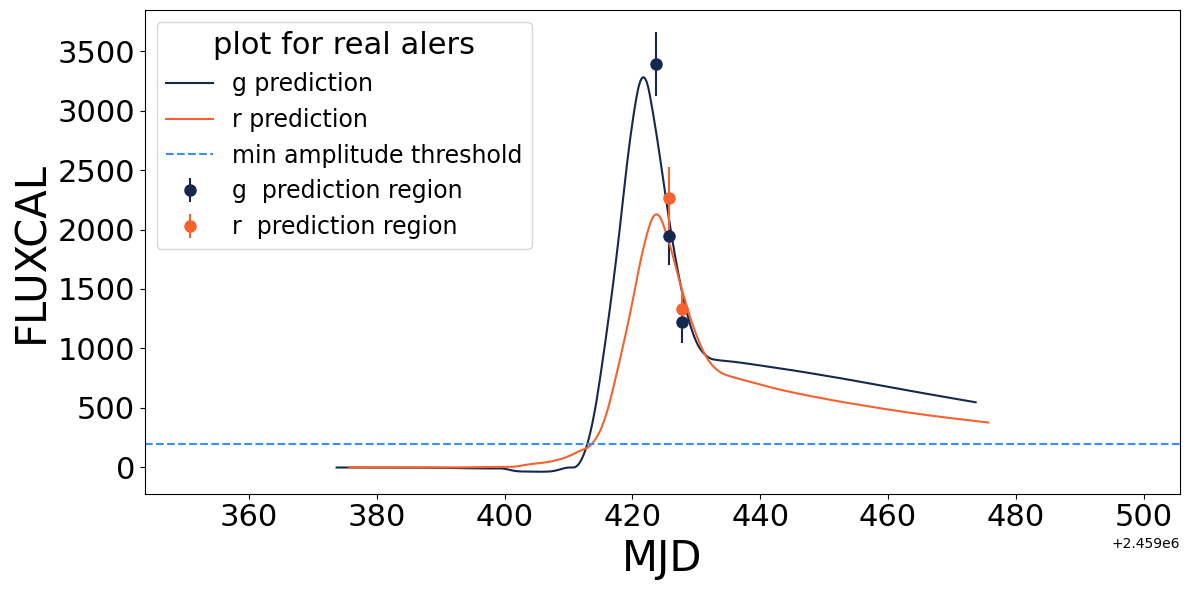

In [25]:
from kndetect.plot_lightcurve import plot_predicted_bands
color_band_dict = {b'g': '#15284F', b'r': '#F5622E'}
count = 0
flux_lim=200
for indx, row in data.iterrows():
    snid = row["objectId"]
    # print(indx)
 
    #object_data = data[data["objectId"]==snid]
    if row["new_model_scores"]<=.5:
        continue
    #indx = list(row['candid'].values).index(lcs_complete.iloc[pos]['candid'])
    flag = np.array([row['cmagpsf'][i] != None for i in range(len(row['cmagpsf']))])
    # print(lcs_complete.iloc[pos]['candid'])
    mag = np.array(row['cmagpsf'])[flag]
    magerr = np.array(row['csigmapsf'])[flag]


    flux_data = [mag2fluxcal_snana(*args) for args in zip(
        mag,
        magerr)]
    flux, error = np.transpose(flux_data)

    lc = {}
    lc['SNID'] = indx
    lc['MJD'] = np.array(row['cjd'])[flag]
    lc['FLT'] = pd.Series(np.array(row['cfid'])[flag])
    #lc['FLT'].replace({1: 'g', 2: 'r'}, inplace=True)

    lc['FLUXCAL'] = flux
    lc['FLUXCALERR'] = error
    
    lc['mag'] = np.array(row['cmagpsf'])[flag]
    lc['magerr'] = np.array(row['csigmapsf'])[flag]
    lc['FLT'].replace({1: b'g', 2: b'r'}, inplace=True)
    
    lc = pd.DataFrame(lc)

    object_features = features_df[features_df["key"]==indx].squeeze()
    #print(object_features)
    band_coeff_dict = get_band_coeff_dict(object_features)
    #print(band_coeff_dict)
#     print(snid)
    print(row['new_model_scores'])
#     print(band_coeff_dict)
    plot_predicted_bands(lc=lc, all_band_coeff_dict=band_coeff_dict, features=object_features, color_band_dict=color_band_dict, flux_lim=flux_lim, pcs=load_pcs(), band_map={b'r': 'r',b'g':'g'}, legend_title="plot for real alers", plot_unused_points=False)
    plt.show()
    plt.close()
    count+=1
    if count == 20:
        break

ZTF21abgcgyq
0.5666666666666667


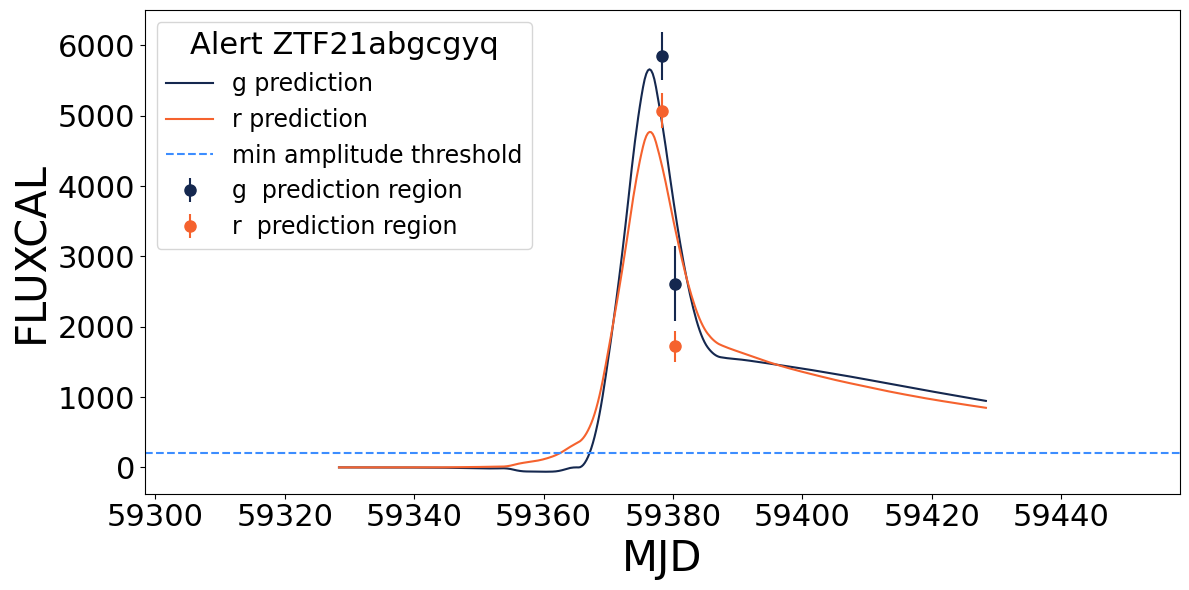

In [23]:
color_band_dict = {b'g': '#15284F', b'r': '#F5622E'}
count = 0
flux_lim=200

snid = "ZTF21abgcgyq"
candid = 1626368700115015001

row = data[data["candid"]==candid].iloc[0]
#print(row)
snid = row["objectId"]
#indx = list(row['candid'].values).index(lcs_complete.iloc[pos]['candid'])
flag = np.array([row['cmagpsf'][i] != None for i in range(len(row['cmagpsf']))])
# print(lcs_complete.iloc[pos]['candid'])
mag = np.array(row['cmagpsf'])[flag]
magerr = np.array(row['csigmapsf'])[flag]


flux_data = [mag2fluxcal_snana(*args) for args in zip(
    mag,
    magerr)]
flux, error = np.transpose(flux_data)

lc = {}
lc['SNID'] = indx
lc['MJD'] = np.array(row['cjd'])[flag] - 2400000.5
lc['FLT'] = pd.Series(np.array(row['cfid'])[flag])
#lc['FLT'].replace({1: 'g', 2: 'r'}, inplace=True)

lc['FLUXCAL'] = flux
lc['FLUXCALERR'] = error

lc['mag'] = np.array(row['cmagpsf'])[flag]
lc['magerr'] = np.array(row['csigmapsf'])[flag]
lc['FLT'].replace({1: b'g', 2: b'r'}, inplace=True)

lc = pd.DataFrame(lc)

object_features = features_df[features_df["key"]==indx].squeeze()
#print(object_features)
band_coeff_dict = get_band_coeff_dict(object_features)
#print(band_coeff_dict)
print(snid)
print(row['new_model_scores'])

plot_predicted_bands(lc=lc, all_band_coeff_dict=band_coeff_dict, features=object_features, color_band_dict=color_band_dict, flux_lim=flux_lim, pcs=load_pcs(), band_map={b'r': 'r',b'g':'g'}, legend_title="Alert "+snid, plot_unused_points=False)
plt.savefig("results/real_alert_plot.pdf")
plt.savefig("results/real_alert_plot")
plt.show()
plt.close()